### Figure 2 : Ripple oscillations

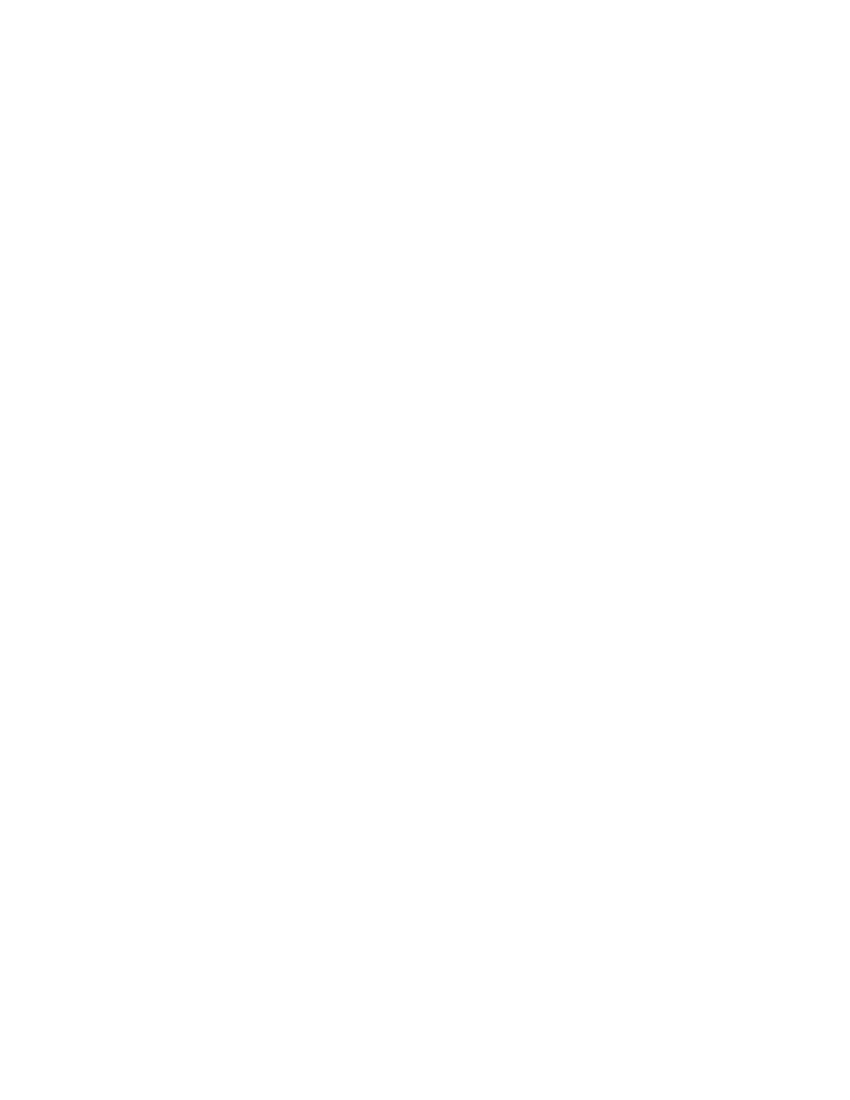

In [15]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import subjects
from subjects import sd_span, nsd_span, grp_span
import pandas as pd
import seaborn as sns
from neuropy.plotting import Fig
from scipy import stats


grpdata = subjects.GroupData()
group = ["nsd", "sd"]

# ripple
psd = grpdata.ripple_psd

rate = grpdata.ripple_rate
colors_ripple_rate = subjects.colors_sd(1.3)

total_dur = grpdata.ripple_total_duration
colors_rpl_dur = subjects.colors_sd(1.2)

peak_freq = grpdata.ripple_peak_frequency
colors_pf = subjects.colors_sd(1.3)

# pbe

pbe_rate = grpdata.pbe_rate
pbe_total_dur = grpdata.pbe_total_duration

# frate
frate_rpl_pyr = grpdata.frate_pyr_in_ripple
frate_rpl_pyr["neuron"] = "pyr"
frate_rpl_inter = grpdata.frate_inter_in_ripple
frate_rpl_inter["neuron"] = "inter"
frate_rpl = pd.concat([frate_rpl_pyr, frate_rpl_inter], axis=0, ignore_index=True)
colors_frate = [
    [subjects.nsd.color(1.1), subjects.nsd.color(1.4)],
    [subjects.sd.color(1.1), subjects.sd.color(1.3)],
]

fig = Fig(grid=(5, 4), hspace=0.45, wspace=0.4)
filename = subjects.figpath_sd / "figure2"
caption = "Ripple and PBEs compared between SD and NSD sessions.\n(A) Mean ripple power spectral density across SD and NSD sessions during Pre, Maze and POST. Error bars indicate +/- SEM.\n(B) Distribution of peak ripple frequency calculated using wavelet compared across SD (orange) and NSD (purple) at selected epochs of each session. \n(C) Rate of ripple occurence during POST of SD (top left) and NSD (top right) sessions. Black dashed line represent median across sessions. Bottom panel shows integrated ripple duration during POST. \n(D) Same as (C) but of PBE events. \nE) Normalized z-scored firing rate within ripples calculated at various epochs for pyramidal and interneurons. Error bars indicate 90% CI."


### Power spectrum

In [16]:
from scipy.signal import find_peaks

psd_colors = [
    ["#BDBDBD", "#EA80FC", subjects.nsd.color(1.2)],
    ["#BDBDBD", "#EA80FC", "#FF8A80", "#00B8D4"],
]
# psd_colors = [subjects.sd.color(1), subjects.nsd.color(1)]
# markers = [[".", ",", "^", "x"], [".", ",", "^"]]
psd_epochs = [["pre", "maze", "post"], ["pre", "maze", "sd", "rs"]]

gs_ = fig.subplot2grid(fig.gs[0, :2], grid=(1, 5), wspace=0)
psd_ = psd[(psd["freq"] > 60) & (psd["freq"] < 300)]
psd_ = psd_.groupby("grp")
for i, (grp, ep, col) in enumerate(zip(group, psd_epochs, psd_colors)):
    e_psd = psd_.get_group(grp).groupby("Epoch")
    peak = []
    ax = plt.subplot(fig.gs[i])
    for e, epoch in enumerate(ep):
        sem = e_psd.get_group(epoch).groupby("freq").sem(ddof=0).psd
        mean = e_psd.get_group(epoch).groupby("freq").mean()
        f = mean.index
        peak.append(f[find_peaks(mean.psd)[0][0]])
        ax.plot(f, mean.psd, "-.", color=col[e])
        # ax.scatter(f,mean.psd,marker=marker[e],s=10,alpha=0.6,linewidths=0.5,edgecolors='w')
        ax.fill_between(
            f,
            mean.psd - sem,
            mean.psd + sem,
            alpha=0.2,
            edgecolor=None,
            linewidth=0,
            color=col[e],
        )

        ax.set_yscale("log")
        # ax.set_yscale('log')
        ax.set_xlim([60, 300])
        ax.set_ylim([50, 2600])

        if i == 0:
            ax.set_title("Ripple power spectrum")
            fig.panel_label(ax, "A")

    ax.scatter(
        peak,
        60 * np.ones_like(peak),
        marker="v",
        s=20,
        c=psd_colors[i],
        alpha=0.8,
        edgecolors="none",
    )
    fig.legend(ax, ep, psd_colors[i])
    ax.set_ylabel("Power")
    ax.set_xlabel("Frequency (Hz)")


### Peak frequency

In [17]:
ax = plt.subplot(fig.gs[0, 2:])
v = sns.violinplot(
    data=peak_freq,
    x="t",
    y="f",
    hue="grp",
    hue_order=group,
    palette=colors_pf,
    legend=None,
    marker="o",
    split=True,
    inner="quartile",
    linewidth=1,
    saturation=1,
    ax=ax,
)
ax.set_ylim(bottom=60)
sd_span(ax,s=2,w=2,h=0.05)
ax.legend([], frameon=False)
ax.set_ylabel("Frequency (Hz)")
ax.set_xlabel("Time")
ax.set_title("Peak ripple frequency", loc="left")
fig.legend(ax, [_.upper() for _ in group], colors_pf, x=0.82, y=0.94)
# ax.grid(True)
fig.panel_label(ax, "B")


### Ripple rate

In [18]:
for i, grp in enumerate(group):
    df = rate[rate["grp"] == grp]
    ax = plt.subplot(fig.gs[1, i])
    sns.lineplot(
        data=df,
        x="Zt",
        y="rate",
        ax=ax,
        hue="sub",
        legend=False,
        palette=[colors_ripple_rate[i]] * 8,
        # ls="--",
    )
    sns.lineplot(
        data=df,
        x="Zt",
        y="rate",
        estimator=np.median,
        ax=ax,
        legend=False,
        color="k",
        ls="--",
        ci=None,
        lw=2,
    )
    # ax.set_yscale('log')
    ax.set_xlim([0.7, 9.3])
    ax.set_ylim([0.08, 0.65])
    if grp == "sd":
        sd_span(ax, s=0, w=5, h=0.05)
    ax.set_xticks(np.arange(1, 10, 2))
    fig.legend(ax, [grp.upper()], [colors_ripple_rate[i]])

    if i == 0:
        ax.set_ylabel("Rate (Hz)")
        ax.set_title("Ripples in POST", loc="left")
        fig.panel_label(ax, "C")


ax = plt.subplot(fig.gs[2, :2])

for i, grp in enumerate(group):
    df = total_dur[total_dur["grp"] == grp]
    mean = df.groupby("Zt").mean()
    sem = df.groupby("Zt").sem(0).rpl_duration
    ax.errorbar(
        mean.index.values.astype("int") + np.random.rand(9) * 0.2,
        mean.rpl_duration,
        sem,
        marker="o",
        # fmt='none',
        color=colors_rpl_dur[i],
        capsize=2,
        markeredgecolor="w",
        # alpha=0.6,
    )
grp_span(ax, s=1, w=4, h=0.05)
# ax.plot(mean.index.values.astype('int'),mean.rpl_duration)

# cat_val = df['Zt'].values.astype('int')
# if i==0:

#     df['zt_cat']= np.where(cat_val<6,'sd','rs')
# else:
#     df['zt_cat']='post'

# sns.pointplot(
#     data=df,
#     x="Zt",
#     y="rpl_duration",
#     hue="zt_cat",
#     legend=False,
#     color=dur_colors[i],
#     # marker="o",
#     estimator=np.mean,
#     ax=ax,
#     ci=None,
#     # join=False,
#     # ls="--",
# )
# ax.legend('',frameon=False)

ax.set_title("Integrated ripple duration", loc="left")
ax.set_ylabel("Duration (s)")
ax.set_xlabel("Zt time (h)")
# sns.barplot(data=total_dur,x='Zt',y='rpl_duration',hue='grp',ax=ax)


Text(0.5, 0, 'Zt time (h)')

### Pbe rate

In [19]:
n_subs = [6, 7]
for i, grp in enumerate(group):
    df = pbe_rate[pbe_rate["grp"] == grp]
    ax = plt.subplot(fig.gs[1, i + 2])
    sns.lineplot(
        data=df,
        x="Zt",
        y="rate",
        ax=ax,
        hue="sub",
        legend=False,
        palette=[colors_ripple_rate[i]] * n_subs[i],
        # ls="--",
    )
    sns.lineplot(
        data=df,
        x="Zt",
        y="rate",
        estimator=np.median,
        ax=ax,
        legend=False,
        color="k",
        ls="--",
        ci=None,
        lw=2,
    )
    # ax.set_yscale('log')
    ax.set_ylim([0.0, 0.5])
    ax.set_xticks(np.arange(1, 10, 2))
    ax.set_ylabel("Rate")

    if grp =='sd':
        sd_span(ax,s=0,w=5,h=0.05)

    if i == 0:
        ax.set_title("PBE in POST", loc="left")
        fig.panel_label(ax, "D")

ax = plt.subplot(fig.gs[2, 2:])

for i, grp in enumerate(group):
    df = pbe_total_dur[pbe_total_dur["grp"] == grp]
    mean = df.groupby("Zt").mean()
    sem = df.groupby("Zt").sem(0).pbe_duration
    ax.errorbar(
        mean.index.values.astype("int") + np.random.rand(9) * 0.2,
        mean.pbe_duration,
        sem,
        marker="o",
        color=colors_rpl_dur[i],
        capsize=2,
        markeredgecolor="w",
        # alpha=0.6,
    )
    # sns.lineplot(
    #     data=total_dur,
    #     x="Zt",
    #     y="rpl_duration",
    #     hue="grp",
    #     legend=False,
    #     palette=dur_colors,
    #     marker="o",
    #     ax=ax,
    #     ci="sd",
    #     # ls="--",
    # )
grp_span(ax,s=1,w=4,h=0.05)
ax.set_title("Integrated PBE duration", loc="left")
ax.set_ylabel("Duration (s)")
ax.set_xlabel("Zt time (h)")
# sns.barplot(data=total_dur,x='Zt',y='rpl_duration',hue='grp',ax=ax)


Text(0.5, 0, 'Zt time (h)')

### Firing within ripples

In [20]:
for i, grp in enumerate(group):
    df = frate_rpl[frate_rpl["grp"] == grp]
    mean = df.groupby("time").mean()
    sem = df.groupby("time").sem(0).frate
    ax = plt.subplot(fig.gs[3, i])
    # ax.bar(mean.index,mean.frate,color)
    sns.lineplot(
        data=df,
        x="time",
        y="frate",
        hue="neuron",
        # legend=False,
        palette=colors_frate[i],
        ax=ax,
        ci=90,
        marker="o",
        legend=None,
        err_style="bars",
        alpha=0.7,
        # errwidth=1.5,
        # ls="--",
    )

    # ax.errorbar(
    #     list(mean.index.values),
    #     mean.frate.values,
    #     sem,
    #     marker="o",
    #     color=frate_colors[i],
    #     capsize=2,
    #     markeredgecolor="w",
    #     # alpha=0.6,
    # )
    if grp=='sd':
        sd_span(ax,s=2,w=4)
    ax.set_ylim([-0.7, 1.0])
    ax.tick_params("x", labelrotation=90)
    fig.legend(ax, ["pyr", "inter"], colors_frate[i])
    ax.set_ylabel("Firing rate (z-scored)")

    if i == 0:
        ax.set_title("Firing within ripples", loc="left")
        fig.panel_label(ax, "E")


# for i, grp in enumerate(["sd", "nsd"]):
#     df =frate_rpl_inter[frate_rpl_inter["grp"] == grp]
#     mean = df.groupby("time").mean()
#     sem = df.groupby("time").sem(0).frate
#     ax = plt.subplot(gs[2, 2+i])
#     # ax.bar(mean.index,mean.frate,color)
#     sns.barplot(
#         data=df,
#         x="time",
#         y="frate",
#         # hue="grp",
#         # legend=False,
#         color=frate_colors[i],
#         ax=ax,
#         ci=90,
#         errwidth=1.5,
#         # ls="--",
#     )

#     # ax.errorbar(
#     #     list(mean.index.values),
#     #     mean.frate.values,
#     #     sem,
#     #     marker="o",
#     #     color=frate_colors[i],
#     #     capsize=2,
#     #     markeredgecolor="w",
#     #     # alpha=0.6,
#     # )
#     ax.tick_params('x',labelrotation=90)

#     if i==0:
#         ax.set_title('Firing within ripples (interneurons)',loc='left')


### saving

In [ ]:
# fig.savefig(filename,caption=caption)
